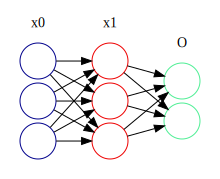

In [2]:
import os
from graphviz import Source

dot = Source(open('graph.dot', 'r').read())
dot

In [3]:
import pandas as pd
from IPython.display import display
import numpy as np

weights = [np.array([[0.3,0.2,-0.4], [-0.9, 0.01, 0.5], [0.1, -0.4, -0.5]]),
           np.array([0.3, 0.1, 0.6]),
           np.array([[0.5, -0.1], [-0.5, -0.1], [0.2, 0.6]]),
           np.array([0.7, 0.2])]

x = np.array([[1,1,0],[1,0,1],[0,1,0],[0,1,1]])
y = np.array([[0, 1], [1, 0], [1, 0], [0, 1]])


display(pd.DataFrame(weights[0], columns=["x11", "x12", "xO"]))
display(pd.DataFrame(weights[1], columns=["bx1"]))
display(pd.DataFrame(weights[2], columns=["O2", "O1"]))
display(pd.DataFrame(weights[3], columns=["bO"]))

,x11,x12,xO
0,0.3,0.20,-0.4
1,-0.9,0.01,0.5
2,0.1,-0.40,-0.5


,bx1
0,0.3
1,0.1
2,0.6


,O2,O1
0,0.5,-0.1
1,-0.5,-0.1
2,0.2,0.6


,bO
0,0.7
1,0.2


In [4]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K


model = Sequential()
model.add(Dense(3, activation='relu', input_shape=(3,)))
model.add(Dense(2, activation='sigmoid'))

model.set_weights(weights)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
input_placeholder = model.input
output_placeholder = [layer.output for layer in model.layers]
activation_functions = [K.function([input_placeholder], [out]) for out in output_placeholder]

In [6]:
activations = [func([x]) for func in activation_functions]


#display(pd.DataFrame(activations[0]))
activations

[[array([[-0.        ,  0.31      ,  0.70000005],
         [ 0.70000005, -0.        , -0.        ],
         [-0.        ,  0.11      ,  1.1       ],
         [-0.        , -0.        ,  0.6       ]], dtype=float32)],
 [array([[0.6648537 , 0.64313567],
         [0.74077487, 0.5324543 ],
         [0.70370424, 0.7003573 ],
         [0.69423634, 0.63645256]], dtype=float32)]]

In [7]:

model.predict(np.array(x))

array([[0.6648537 , 0.64313567],
       [0.74077487, 0.5324543 ],
       [0.70370424, 0.7003573 ],
       [0.69423634, 0.63645256]], dtype=float32)

In [8]:

from IDNNs.idnns.information import information_process


model.save_file = False

information_process.get_information(activations, x, y, 10, 1, model, [3])

Start calculating the information...
Starting the prob calculation
Finished the prob calculation
Calculated The information of epoch number - 0
Calculated The information of epoch number - 1
[[{'local_IXT': 2.0, 'local_ITY': 1.0}]
 [{'local_IXT': 0.8112781244591328, 'local_ITY': 0.31127812445913283}]]


array([[{'local_IXT': 2.0, 'local_ITY': 1.0}],
       [{'local_IXT': 0.8112781244591328, 'local_ITY': 0.31127812445913283}]],
      dtype=object)

Berechnung der Wahrscheinlichkeiten der X und Y Daten

In [12]:

# Wahrscheinlichkeit, zufällig eine der zwei Klassen zu ziehen. 
# Klasse 1 und 2 kommen jeweils 2 mal vor. 4 Insgesamt => 2 / 4 = 0.5
pys = np.sum(y, axis=0) / float(y.shape[0])

b = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
unique_array, unique_indices, unique_inverse_x, unique_counts = np.unique(b, True, True, True)


_unique_array, _unique_indices, _unique_inverse_x, _unique_counts = np.unique(x, True, True, True, axis=0)
display(unique_array)
display(_unique_array)

display(unique_indices)
display(_unique_indices)

display(unique_inverse_x)
display(_unique_inverse_x)

display(unique_counts)
display(_unique_counts)

unique_a = x_local[unique_indices]
#b1 = np.ascontiguousarray(unique_a).view(np.dtype((np.void, unique_a.dtype.itemsize * unique_a.shape[1])))

pxs = unique_counts / float(np.sum(unique_counts))
#display(unique_inverse_x)
p_y_given_x = []
for i in range(0, len(unique_array)):
    indexs = unique_inverse_x == i
    #display(x_local[indexs])
    #display(y_local[indexs])
    #display("")
    p_y_x_current = np.mean(y_local[indexs, :], axis=0)
    p_y_given_x.append(p_y_x_current)
    
p_y_given_x = np.array(p_y_given_x).T

# display(p_y_given_x)
# display(unique_inverse_x)
# y_local

#b_y = np.ascontiguousarray(y_local).view(np.dtype((np.void, y_local.dtype.itemsize * y_local.shape[1])))
display(b_y)
unique_array_y, unique_indices_y, unique_inverse_y, unique_counts_y = np.unique(y_local, return_index=True, return_inverse=True, return_counts=True, axis=0)

display(y_local)

array([b'\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
       b'\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'],
      dtype='|V24')

array([[0, 1, 0],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]])

array([2, 3, 1, 0])

array([2, 3, 1, 0])

array([3, 2, 0, 1])

array([3, 2, 0, 1])

array([1, 1, 1, 1])

array([1, 1, 1, 1])

NameError: name 'x_local' is not defined

Binning der Activations values

In [ ]:
num_of_bins = 10

data_layer1 = np.squeeze(np.array(activations[1]))
#display(data_layer1.shape)

bins = np.linspace(-1, 1, num_of_bins)

binned = bins[np.digitize(np.squeeze(data_layer1.reshape(1, -1)), bins) -1].reshape(len(data_layer1), -1)

#b_binned = np.ascontiguousarray(binned).view(np.dtype((np.void, binned.dtype.itemsize * binned.shape[1])))
unique_array_binned, unique_inverse_t, unique_counts_binned = np.unique(binned, return_index=False, return_inverse=True, return_counts=True, axis=0)
display(unique_inverse_t)
unique_array_binned


In [ ]:
def calc_condition_entropy_for_given_y(t_data_for_i, px_for_i):
    b = np.ascontiguousarray(t_data_for_i).view(np.dtype((np.void, t_data_for_i.dtype.itemsize * t_data_for_i.shape[1])))
    unique_array, unique_counts = np.unique(b, return_counts=True)
    
    p_current_t = unique_counts / float(sum(unique_counts))
    
    display(p_current_t)
    
    H = px_for_i * (-np.sum(p_current_t * np.log2(p_current_t)))
    
    return H

In [ ]:
# Wahrscheinlichkeit für einen der gebinnten werte des Layers T
p_ts = unique_counts_binned / float(sum(unique_counts_binned))
# Entropie des layers T
H_t = -np.sum(p_ts * np.log2(p_ts))
H_t

display(unique_counts_binned)

#display(unique_inverse_y)

H_T_given_X_array = [calc_condition_entropy_for_given_y(binned[unique_inverse_x == i,:], pxs[i]) for i in range(pxs.shape[0])]

H_T_given_Y_array = [calc_condition_entropy_for_given_y(binned[unique_inverse_y == i,:], pys[i]) for i in range(pys.T.shape[0])]

H_T_given_X = np.sum(H_T_given_X_array)
H_T_given_Y = np.sum(H_T_given_Y_array)

I_X = H_t - H_T_given_X
I_Y = H_t - H_T_given_Y

display("-----------")
display(I_X)
display(I_Y)


$$H(X|Y) = \sum_{y\in L:P(Y=y)>0}{P(Y=y) H(X|Y=y)}$$

$$H(T|X) = \sum_{x\in L:P(X=x)>0}{P(X=x) H(T|X=x)}$$